## Short Answer Grading Via Regular Expressions

The idea is simple, let teachers define a list of concepts and write regular expressions which match for those concepts.
If the regular expression matches it signifies that the student has that concept in their short answer response and the student gets full credit.
For a question with 3 concepts, a student who gets 2 concepts would have a normalized score of 2/3 or 0.67. If the question awards 10 total points on an integer
scale, then the final point total awarded to that student would be 7 after rounding.

Optionally, teachers can provide partial credit regular expressions which are run after the full credit ones for concepts the student failed to match for full credit. If a partial credit match is found it can receive a point score defined by the teacher, with a maximum of 1.0 (like full credit ones) and a default of 0.5.

In the above example, if a student matched for partial credit on the 3rd concept then he would have 2.5/3 or 0.83 which when scaled would boost his point total to 8/10.

### Pros

1. Easy to interprete grading scheme.
2. Straight forward interpretation for both students and teachers. i.e. does the student response match a pattern or not.
3. Nice Formative Feedback. Both Student and Teacher can view which concepts they got right and which ones they missed, not only that but its easy to interpret why b/c the teacher 
or student only has to look at the student response and see what causes it not to match a regular expression.

### Cons

1. Time consuming initial setup process. Teachers must write a list of regular expressions, this takes time and could lead to a preference for other question types such as multiple choice or fill in the blank.
2. Scoring is directly tied to concepts. Student's cannot receive points for anything beyond precisely identifying concepts which have been listed by the professor.

In [107]:
from importlib import reload
import re
import sys
sys.path.append('../../')
import libs.scoring_methods as sm
import numpy as np
import pandas as pd
import asag_regex as asag_re
import json
reload(asag_re)

<module 'asag_regex' from '/home/che/Work/research/masters_project/automatic_question_answering/research/notebooks/research_full/syntax/01_regex_exp/asag_regex.py'>

In [158]:
# import the data
df = pd.read_csv('../../data/asag.csv', sep='~')
display(df.head(3))

# import the first user annotated dataset
df_u1 = pd.read_csv('../../data/regex_asag/asag_regex_p1_adj.csv', sep='~')
display(df_u1.head(3))

AID  QID                                   Prompt  \
0    1    1  What does a function signature include?   
1    1    1  What does a function signature include?   
2    1    1  What does a function signature include?   

                                        Model Answer  Score  SID  \
0  The name of the function and the types of the ...    4.5    6   
1  The name of the function and the types of the ...    3.0    5   
2  The name of the function and the types of the ...    5.0    8   

                                      Student Answer  
0  It includes the name of the program, the type ...  
1  it includes the specific information about the...  
2  The function signature includes the name of th...

AID  QID                                          Prompt  \
0    1    1         What does a function signature include?   
1    1    2          What is the scope of global variables?   
2    1    3  How does the compiler handle inline functions?   

                                        Model Answer  \
0  The name of the function and the types of the ...   
1                                        File scope.   
2  It makes a copy of the function code in every ...   

                                 Full Credit Matches  \
0  {\n    "name_of_function" : [\n        "names?...   
1  {\n    "file_scope" : [\n        "file",\n    ...   
2  {\n    "copy_function_code" : [\n        "copy...   

                              Partial Credit Matches  
0  {\n    "name_of_function" : [\n        "names?...  
1                                                 {}  
2  {\n    "copy_function_code" : [\n        "cop(...

In [161]:
reload(asag_re)
def evaluate_regex(df, user_df, debug=False):
    
    actual_scores = df['Score'].as_matrix()
    pred_scores = []
    raw_scores = []
    match_info = []
    miss_count = 0
    
    for index, row in df.iterrows():
        aid = row['AID']
        qid = row['QID']
        
        #if debug:
        #    print('Assignment/Question/SID: [{}|{}|{}]'.format(aid, qid, row['SID']))
        
        full_credit_re = json.loads(user_df[np.logical_and(user_df['AID'] == aid, user_df['QID'] == qid)]['Full Credit Matches'].iloc[0].replace("\\", "\\\\"))
        partial_credit_re = json.loads(user_df[np.logical_and(user_df['AID'] == aid, user_df['QID'] == qid)]['Partial Credit Matches'].iloc[0].replace("\\", "\\\\"))
        
        student_response = row['Student Answer']
        
        score, matches = asag_re.analyze(student_response.lower(), full_credit_re, partial_credit_re)
        if score < 0.1 and debug:
            print("PROMPT: {}".format(row['Prompt']))
            print("STUDENT: {}".format(student_response))
            print("MODEL: {}".format(row['Model Answer']))
            print("MATCHES: {}".format(full_credit_re))
        elif score < 0.1:
            miss_count += 1
        match_info.append(matches)
        
        # scale the score
        scaled_score = np.round(score * 5)
        raw_scores.append(score)
        pred_scores.append(scaled_score)
    
    
    
    return {
        'y_true' : np.round(actual_scores), 
        'y_pred' : np.array(pred_scores),
        'y_raw_true' : actual_scores,
        'y_raw_pred' : np.array(raw_scores), 
        'match_info' : np.array(match_info),
        'misses' : miss_count
    }

result = evaluate_regex(df, df_u1, debug=False)

405


Accuracy: 15.71%
Precision: 39.53%
Recall: 15.71%
F1-Measure: 20.21%
Pearson's R: 0.37
Cohen's Kappa: 0.05
RMSE: 3.34
Y-True Mean: 4.03
Y-Pred Mean: 1.25
Y-True Std Deviation: 1.18
Y-Pred Std Deviation: 1.92


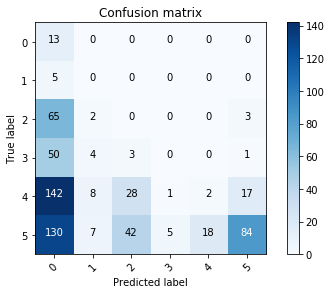

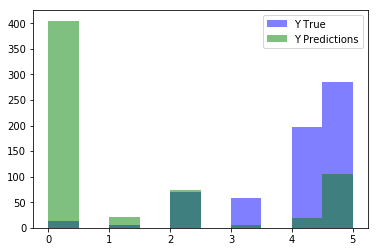

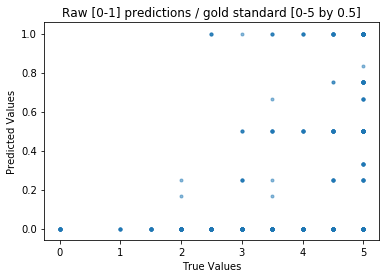

In [163]:
sm.print_big4(y_true, y_pred)
sm.print_stats(y_true, y_pred)
sm.plot_confusion_matrix(sm.cm(y_true, y_pred), np.arange(6))
sm.plot_histogram_comparison(y_true, y_pred, bins=10)
sm.plot_scatter(df['Score'].as_matrix(), y_raw)